# Classification Trees

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

# Table of Contents

1. [CART: classification and regression tree](#1-cart-classification-and-regression-tree)  
   1.1 [Classification Trees (Credit Card Default data)](#11-classification-trees-credit-card-default-data)  
   1.1.1 [Printing and ploting the tree](#111-printing-and-ploting-the-tree)  
   1.1.2 [Prediction using classification trees](#112-prediction-using-classification-trees)  
   1.1.3 [Calculate the actual cost using a self-defined cost function.](#113-calculate-the-actual-cost-using-a-self-defined-cost-function)  
   1.1.4 [Comparing this classification tree with logistic regression](#114-comparing-this-classification-tree-with-logistic-regression)  
   1.1.5 [ROC Curve and Cut-off Probability for Classification trees](#115-roc-curve-and-cut-off-probability-for-classification-trees)  
   1.2 [Things to remember](#12-things-to-remember)  


---

#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1kDxbq8xccQUQkSZJPyOCLRUAE90xwB5c?usp=sharing)*
#### *Useful information about [Classification Trees](https://yanyudm.github.io/Data-Mining-R/lecture/6.B_ClassTree.html)*




# 1 CART: classification and regression tree

CART stands for classification and regression trees:
* Regression tree: response variable Y is numerical
* Classification tree: response variable Y is categorical

For the regression tree example, we will use the Boston Housing data. Recall the response variable is the housing price. For the classification tree example, we will use the credit scoring data. The response variable is whether the loan went to default.

Note that unlike logistic regression, the response variable does not have to be binary in case of classification tree. We can use classification tree on classification problems with more than 2 outcomes.

## 1.1 Classification Trees (Credit Card Default data)

The classification trees is slightly more complicated to specify. What makes it more complicated is that we often have asymmetric cost function. In the credit scoring case it means that false negatives (predicting 0 when truth is 1, or giving out loans that end up in default) will cost more than false positives (predicting 1 when truth is 0, rejecting loans that you should not reject).

Here we make the assumption that false negative cost 5 times of false positive. In real life the cost structure should be carefully researched.



In [1]:
# ------------------------------------------------------------
# CART (Classification Tree) in Python (Google Colab)
# R equivalents:
#   - rpart(..., method="class")              -> sklearn.tree.DecisionTreeClassifier
#   - parms=list(loss=matrix(c(0,5,1,0),2))   -> class_weight + custom threshold (pcut = 1/(5+1))
#   - predict(..., type="class"/"prob")       -> predict / predict_proba
#   - ROCR ROC + AUC                          -> sklearn.metrics.roc_curve + auc
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1) Read data + rename response
# -----------------------------
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(url).rename(columns={"default.payment.next.month": "default"})

# Convert categorical columns to "factor-like" (category)
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")

print("Mean default rate:", f"{credit_data['default'].mean():.4f}")



Mean default rate: 0.2193


In [2]:

# -----------------------------------------
# 2) Dummy encoding (Python needs numeric X)
#    R rpart can handle factors directly.
# -----------------------------------------
X_raw = credit_data.drop(columns=["default"])
y = credit_data["default"].astype(int)

X = pd.get_dummies(X_raw, drop_first=True)  # treatment coding, like typical model.matrix usage
feature_names = X.columns.to_list()



In [3]:
# -----------------------------
# 3) Train/test split (80/20)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123, shuffle=True
)

print(f"\nTrain X shape: {X_train.shape}, Train y shape: {y_train.shape}")
print(f"Test  X shape: {X_test.shape},  Test  y shape: {y_test.shape}")

# ------------------------------------------------------------
# Helper: confusion table like R's table(...)
# ------------------------------------------------------------
def conf_table(y_true, y_pred, row_name="Truth", col_name="Predicted"):
    return pd.crosstab(
        pd.Series(y_true, name=row_name),
        pd.Series(y_pred, name=col_name),
        dropna=False
    )

# ------------------------------------------------------------
# Helper: asymmetric cost function (same logic as your R code)
#   weight1 = cost of false negative (true 1, predict 0)
#   weight0 = cost of false positive (true 0, predict 1)
#   pcut = weight0 / (weight1 + weight0) = 1/6 when weight1=5, weight0=1
# ------------------------------------------------------------
def cost_asymmetric(r, phat, weight1=5, weight0=1):
    r = np.asarray(r).astype(int)
    phat = np.asarray(phat).astype(float)
    pcut = weight0 / (weight1 + weight0)
    c1 = (r == 1) & (phat < pcut)   # false negatives
    c0 = (r == 0) & (phat > pcut)   # false positives
    return np.mean(weight1 * c1 + weight0 * c0), pcut




Train X shape: (9600, 26), Train y shape: (9600,)
Test  X shape: (2400, 26),  Test  y shape: (2400,)


In [4]:
# ------------------------------------------------------------
# 4) Baseline classification tree (unweighted)
#    R: credit_rpart0 <- rpart(default ~ ., data=credit_train, method="class")
# ------------------------------------------------------------
tree0 = DecisionTreeClassifier(random_state=123)
tree0.fit(X_train, y_train)

pred0_train = tree0.predict(X_train)
print("\n--- Baseline tree (unweighted): confusion matrix on TRAIN ---")
display(conf_table(y_train, pred0_train, row_name="True", col_name="Pred"))


--- Baseline tree (unweighted): confusion matrix on TRAIN ---


Pred,0,1
True,,
0,4622,1371
1,1368,321


### 1.1.1 Printing and ploting the tree


--- Cost-sensitive tree: model object ---
DecisionTreeClassifier(class_weight={0: 1, 1: 5}, random_state=123)

--- Tree structure (text, first few levels) ---
|--- PAY_0 <= 0.50
|   |--- PAY_AMT2 <= 2888.50
|   |   |--- PAY_4 <= 1.00
|   |   |   |--- PAY_AMT3 <= 810.50
|   |   |   |   |--- truncated branch of depth 29
|   |   |   |--- PAY_AMT3 >  810.50
|   |   |   |   |--- truncated branch of depth 27
|   |   |--- PAY_4 >  1.00
|   |   |   |--- BILL_AMT3 <= 787.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- BILL_AMT3 >  787.00
|   |   |   |   |--- truncated branch of depth 21
|   |--- PAY_AMT2 >  2888.50
|   |   |--- PAY_4 <= 1.00
|   |   |   |--- PAY_AMT2 <= 19473.00
|   |   |   |   |--- truncated branch of depth 24
|   |   |   |--- PAY_AMT2 >  19473.00
|   |   |   |   |--- truncated branch of depth 9
|   |   |--- PAY_4 >  1.00
|   |   |   |--- LIMIT_BAL <= 25000.00
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- LIMIT_BAL >  25000.00
|   |   

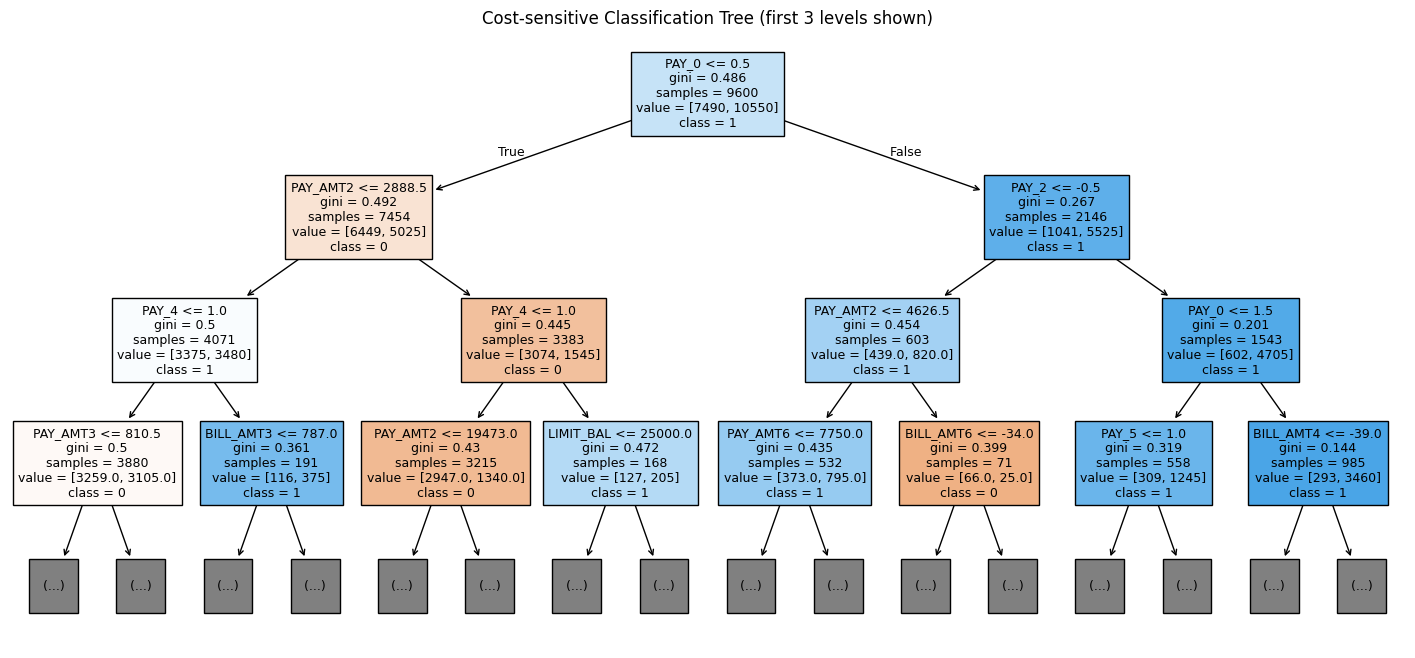

In [5]:

# ------------------------------------------------------------
# 5) Cost-sensitive classification tree
#    R: parms=list(loss=matrix(c(0,5,1,0), nrow=2))
#    Interpretation: FN cost (true=1, pred=0) is higher (≈5x).
#    In sklearn, we approximate this via class_weight and then apply pcut=1/6.
# ------------------------------------------------------------
tree_cost = DecisionTreeClassifier(
    random_state=123,
    class_weight={0: 1, 1: 5}  # emphasize the minority/positive class
)
tree_cost.fit(X_train, y_train)

print("\n--- Cost-sensitive tree: model object ---")
print(tree_cost)

# "Printing" the tree (text)
print("\n--- Tree structure (text, first few levels) ---")
print(export_text(tree_cost, feature_names=feature_names, max_depth=3))

# "Plotting" the tree (visual)
plt.figure(figsize=(18, 8))
plot_tree(
    tree_cost,
    feature_names=feature_names,
    class_names=["0", "1"],
    filled=True,
    max_depth=3,   # increase/remove if you want the full tree (can be very large)
    fontsize=9
)
plt.title("Cost-sensitive Classification Tree (first 3 levels shown)")
plt.show()



### 1.1.2 Prediction using classification trees

In-sample prediction

In [6]:
# ------------------------------------------------------------
# 6) Prediction with the cost-sensitive tree
#    R: predict(..., type="class") and predict(..., type="prob")[,2]
# ------------------------------------------------------------
proba_train_tree = tree_cost.predict_proba(X_train)[:, 1]
proba_test_tree  = tree_cost.predict_proba(X_test)[:, 1]

# Threshold implied by 5:1 cost ratio
train_cost, pcut = cost_asymmetric(y_train, proba_train_tree, weight1=5, weight0=1)
test_cost, _     = cost_asymmetric(y_test,  proba_test_tree,  weight1=5, weight0=1)

pred_train_tree = (proba_train_tree > pcut).astype(int)
pred_test_tree  = (proba_test_tree  > pcut).astype(int)



print(f"\nAsymmetric threshold pcut = {pcut:.6f}  ( = 1/(5+1) )")

print("\n--- Cost-sensitive tree: confusion matrix on TRAIN (threshold pcut) ---")
display(conf_table(y_train, pred_train_tree))


print("\n--- Cost-sensitive tree: confusion matrix on TEST (threshold pcut) ---")
display(conf_table(y_test, pred_test_tree))




Asymmetric threshold pcut = 0.166667  ( = 1/(5+1) )

--- Cost-sensitive tree: confusion matrix on TRAIN (threshold pcut) ---


Predicted,0,1
Truth,,
0,4621,1372
1,1367,322



--- Cost-sensitive tree: confusion matrix on TEST (threshold pcut) ---


Predicted,0,1
Truth,,
0,314,64
1,76,24


**Exercise:** Out-of-sample prediction

## 1.1.3 Calculate the actual cost using a self-defined cost function

In [7]:

# Threshold implied by 5:1 cost ratio
train_cost, pcut = cost_asymmetric(y_train, proba_train_tree, weight1=5, weight0=1)
test_cost, _     = cost_asymmetric(y_test,  proba_test_tree,  weight1=5, weight0=1)

print(f"\nAsymmetric cost on TRAIN (tree): {train_cost:.4f}")
print(f"Asymmetric cost on TEST  (tree): {test_cost:.4f}")


Asymmetric cost on TRAIN (tree): 0.0002
Asymmetric cost on TEST  (tree): 0.7958


## 1.1.4 Comparing this classification tree with logistic regression
We can compare this model’s out-of-sample performance with the logistic regression model with all variables in it.

In [8]:
# ------------------------------------------------------------
# 7) Compare with logistic regression (same cost function)
#    R: glm(default~., family=binomial)
# ------------------------------------------------------------
logit = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LogisticRegression(max_iter=10000))
])
logit.fit(X_train, y_train)

proba_test_glm = logit.predict_proba(X_test)[:, 1]
glm_cost, pcut_glm = cost_asymmetric(y_test, proba_test_glm, weight1=5, weight0=1)

pred_test_glm = (proba_test_glm > pcut_glm).astype(int)

print(f"\nAsymmetric cost on TEST (logistic regression): {glm_cost:.4f}")
print("\n--- Logistic regression: confusion matrix on TEST (threshold pcut=1/6) ---")
display(conf_table(y_test, pred_test_glm))




Asymmetric cost on TEST (logistic regression): 0.6708

--- Logistic regression: confusion matrix on TEST (threshold pcut=1/6) ---


Predicted,0,1
Truth,,
0,146,232
1,45,55


**Exercise:** Comparison for in-sample performance. Which model do you think is better?

## 1.1.5 ROC Curve and Cut-off Probability for Classification trees

Recall that ROC Curve gives you the trade-off between hit rate (1 - false positive) and false negative, and area under the curve (AUC) can be used as a measure of how good the binary classification model performs when you do not know the cost function.

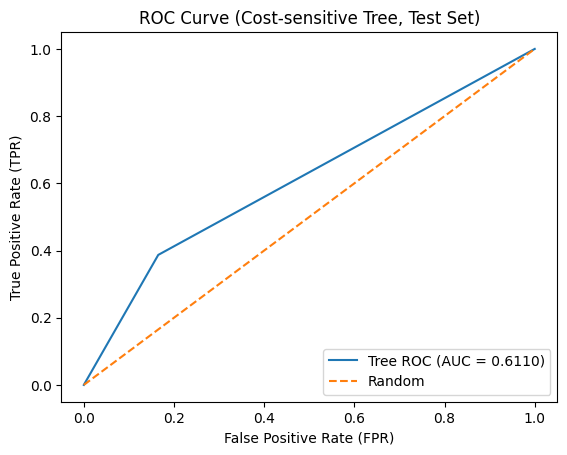

Test AUC (tree): 0.6110


In [9]:

# ------------------------------------------------------------
# 8) ROC curve + AUC for the classification tree (test set)
#    R(ROCR): prediction(prob[,2], y) -> performance("tpr","fpr") -> AUC
# ------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, proba_test_tree)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Tree ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Cost-sensitive Tree, Test Set)")
plt.legend(loc="lower right")
plt.show()

print(f"Test AUC (tree): {roc_auc:.4f}")

### 1.2 Things to remember
1. **Use `DecisionTreeRegressor` and `DecisionTreeClassifier` to fit trees**

   - `DecisionTreeRegressor` is used for continuous outcomes.
   - `DecisionTreeClassifier` is used for categorical or binary outcomes.
   - In scikit-learn, tree inputs must be **numeric**. If you have categorical predictors (e.g., `SEX`, `EDUCATION`, `MARRIAGE`), convert them to dummy variables (e.g., `pd.get_dummies(..., drop_first=True)`).

   - Tree complexity can be controlled using:
     - **Pre-pruning** (limits growth during training):  
       `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`
     - **Post-pruning** (prunes after a large tree is grown):  
       `ccp_alpha` (cost-complexity pruning)

2. **Know how to interpret a tree**

   - Each internal node represents a split on a feature (e.g., `PAY_0 <= 1.5`).
   - Each leaf node stores the training-sample composition at that node:
     - Regression: the leaf predicts a numeric value (often the mean of `y` in that leaf).
     - Classification: the leaf stores class counts, and the predicted probability is the class proportion within the leaf.
   - Use `plot_tree()` to visualize the structure of the tree.
   - Useful model information includes:
     - `tree_.node_count` (number of nodes)
     - `get_depth()` (tree depth)
     - `get_n_leaves()` (number of leaves)

3. **Use `predict()` and `predict_proba()` for prediction and performance assessment**

   - `predict()` returns:
     - Regression: predicted numeric values  
     - Classification: predicted class labels (0/1)
   - `predict_proba()` returns class probabilities for classification (e.g., `P(default=1)`).
   - Common evaluation tools include:
     - Regression: MSE on a validation/test set
     - Classification: confusion matrix, ROC curve, AUC, Precision–Recall curve (AP), and cost-based metrics (if a business cost function is known)

4. **Use cost-complexity pruning to control and prune large trees**

   - Use `cost_complexity_pruning_path()` to obtain a sequence of candidate `ccp_alpha` values.
   - **Larger `ccp_alpha` values** produce **smaller (more pruned)** trees.
   - Use cross-validation (or a validation set) to choose an appropriate `ccp_alpha`.
   - Plot validation error (or a cost metric) against `ccp_alpha` to study the trade-off between tree complexity and predictive performance.


In [ ]:
%%shell
jupyter nbconvert --to html ///content/6_B_Classification_Trees.ipynb